In [ ]:
import numpy as np
import bz2
from collections import Counter
import re
import nltk
import torch
import math
from torch import nn
from torch import optim
from torch import Tensor
from torch import LongTensor
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import logging
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision
import random
from torch.utils.data.sampler import SubsetRandomSampler
from scipy.stats import rankdata
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns

In [ ]:
logging.basicConfig(format='%(asctime)s - %(message)s', datefmt='%d-%b-%y %H:%M:%S')
logging.getLogger().setLevel(logging.INFO)

In [ ]:
%matplotlib inline
# %pylab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_dir = '/content/drive/My Drive/RA - Pathak/Attn/data/'

## Load the dataset

In [ ]:
normalize = transforms.Normalize((0.1307,), (0.3081,))  # MNIST
transform = transforms.Compose([ transforms.ToTensor(), normalize ])

train_dataset = datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

test_dataset = datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

valid_dataset = datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

Extracting /root/torch_datasets/MNIST/raw/train-images-idx3-ubyte.gz to /root/torch_datasets/MNIST/raw


Extracting /root/torch_datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /root/torch_datasets/MNIST/raw


Extracting /root/torch_datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/torch_datasets/MNIST/raw


Extracting /root/torch_datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/torch_datasets/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
bs = 100
valid_size = 0.2
num_workers = 4
pin_memory = True
data_dir = "~/torch_datasets"
shuffle = False
random_seed = 42

# load the dataset
train_dataset = datasets.MNIST(root=data_dir, train=True, 
            download=True, transform=transform)

valid_dataset = datasets.MNIST(root=data_dir, train=True, 
            download=True, transform=transform)

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))

if shuffle == True:
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_dataset, 
                batch_size=bs, sampler=train_sampler, 
                num_workers=num_workers, pin_memory=pin_memory)

val_loader = torch.utils.data.DataLoader(valid_dataset, 
                batch_size=bs, sampler=valid_sampler, 
                num_workers=num_workers, pin_memory=pin_memory)


test_loader = DataLoader(
    test_dataset, batch_size=bs, shuffle=False, num_workers=4
)

In [ ]:
len(train_loader)

480

In [ ]:
len(val_loader)

120

### Old loader

In [ ]:
mnist = np.load("/content/drive/My Drive/RA - Pathak/AFS/data/mnist_rc.npz")

In [ ]:
mnist_train_X, mnist_train_Y, mnist_val_X, mnist_val_Y, mnist_test_X, mnist_test_Y = mnist['train_X'][0], mnist['train_Y'][0], mnist['val_X'], mnist['val_Y'], mnist['test_X'][0], mnist['test_Y'][0]

## convert labels from one-hot encoding to single label
mnist_train_Y = [np.argmax(i) for i in mnist_train_Y]
mnist_val_Y = [np.argmax(i) for i in mnist_val_Y]
mnist_test_Y = [np.argmax(i) for i in mnist_test_Y]

In [ ]:
len(mnist_test_Y)

10000

In [ ]:
batch_size = 100
n_iters = 3000
train_loader = DataLoader(TensorDataset(Tensor(mnist_train_X), LongTensor(mnist_train_Y)), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(Tensor(mnist_val_X), LongTensor(mnist_val_Y)), batch_size=batch_size)
test_loader = DataLoader(Tensor(mnist_test_X), batch_size=batch_size)

### Chek GPU

In [ ]:
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [ ]:
c = torch.rand(1, 28 , 28)
c = c.view(-1,28,28)
c.shape

torch.Size([1, 28, 28])

In [ ]:
device

device(type='cuda')

### LSTM

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_size, drop_prob):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = 2
        self.drop_prob = drop_prob
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
       #self.fc = nn.Linear(2*hidden_dim, output_size)

        ## attention layers
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(p=self.drop_prob)
        self.alpha = nn.Linear(2*self.hidden_dim, 1)
        self.softmax = nn.Softmax(dim=1)
        self.fc = nn.Linear(2*self.hidden_dim, output_size)
        self.softmax_fc = nn.Softmax(dim=1)

        ### Just LSTM layer
        """
        self.fc = nn.Linear(num_layers*self.hidden_dim, 128)
        self.h1 = nn.Linear(128, 64)
        self.h2 = nn.Linear(64, output_size)
        """
        ###
        
    
    def forward(self, x, prev_state):

        out, state = self.lstm(x, prev_state)  # out: tensor of shape (batch_size, seq_length, hidden_dim)
        # print('lstm out', out.shape)
    
        """
        ### JUST LSTM
        out = self.fc(out)
        out = self.h1(out)
        out = self.h2(out)
        # print('fc out',out.shape)
        out = out[:, -1 , :]
        # print('final out',out.shape)
        # raise
        return out, state, _
        ###
        """

        ### ATTENTION LAYER
        out = self.tanh(out)
        out = self.dropout(out)
        a_out = self.alpha(out)
        a_out = self.softmax(a_out)
        # print('a_out',a_out.shape)
        #[100, 784 , 1]

        r_t =  torch.transpose(out, -1 , 1)
        # print('r_t',r_t.shape)
        # [100, 256, 200]
        
        r_out = torch.bmm(r_t, a_out)
        # print('r_out',r_out.shape)
        # [100, 256 , 1]

        out = r_out.squeeze()
        # [100, 256]

        out = self.tanh(out)
        out = self.dropout(out)
        out = self.fc(out)
        out = self.softmax_fc(out)
        # print('final_fc_out',out.shape)
        # [100,10]
        # raise
        return out, state, a_out

    def init_state(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, batch_size, self.hidden_dim))

In [ ]:
def train(train_loader, val_loader, input_dim, sequence_length, hidden_dim, output_size, batch_size, num_epochs):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    # optimizer = optim.RMSprop(model.parameters(), lr=0.01)
    #optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    all_train_loss = []
    all_val_loss = []

    
    for epoch in range(num_epochs):
    
        model.train()

        t_loss = []
        v_loss = []
    
        state_h, state_c = model.init_state(batch_size)
        state_h = state_h.to(device)
        state_c = state_c.to(device)
        
    
        for i, (images, labels) in enumerate(train_loader):
    
            optimizer.zero_grad()
    
            images = images.reshape(-1, sequence_length, input_dim).to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs, h, _ = model(images, (state_h, state_c))
            loss = criterion(outputs, labels)
            t_loss.append(loss.item())
            
            # Backward and optimize
            loss.backward()
            optimizer.step()
        
        all_train_loss.append(np.mean(t_loss))
            
        # Test the model
        model.eval()
        state_v_h, state_v_c = model.init_state(batch_size)
        state_v_h = state_v_h.to(device)
        state_v_c = state_v_c.to(device)

        for images, labels in val_loader:
            images = images.reshape(-1, sequence_length, input_dim).to(device)
            labels = labels.to(device)
            outputs, h, _ = model(images, (state_v_h, state_v_c))
            loss = criterion(outputs, labels)
            v_loss.append(loss.item())
    
        all_val_loss.append(np.mean(v_loss))
    
        logging.info('Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}'  .format(epoch+1, np.mean(t_loss), np.mean(v_loss)))

    return [all_train_loss, all_val_loss, model]

In [ ]:
input_dim = 1
sequence_length = 784
hidden_dim = 128
num_layers = 1
output_size = 10
drop_prob=0.3
num_epochs = 5
batch_size = 100
model = LSTMModel(input_dim, hidden_dim, num_layers, output_size, drop_prob).to(device)
model

LSTMModel(
  (lstm): LSTM(1, 128, batch_first=True, bidirectional=True)
  (tanh): Tanh()
  (dropout): Dropout(p=0.3, inplace=False)
  (alpha): Linear(in_features=256, out_features=1, bias=True)
  (softmax): Softmax(dim=1)
  (fc): Linear(in_features=256, out_features=10, bias=True)
  (softmax_fc): Softmax(dim=1)
)

In [ ]:
lstm = train(train_loader, val_loader, input_dim, sequence_length, hidden_dim, output_size, batch_size, num_epochs)

01-Mar-21 00:53:00 - Epoch [1], train_loss: 2.2264, val_loss: 2.2282
01-Mar-21 00:53:35 - Epoch [2], train_loss: 2.2294, val_loss: 2.2206
01-Mar-21 00:54:09 - Epoch [3], train_loss: 2.1849, val_loss: 2.1365
01-Mar-21 00:54:44 - Epoch [4], train_loss: 2.1517, val_loss: 2.1133
01-Mar-21 00:55:18 - Epoch [5], train_loss: 2.1364, val_loss: 2.1542
01-Mar-21 00:55:53 - Epoch [6], train_loss: 2.1478, val_loss: 2.1435
01-Mar-21 00:56:28 - Epoch [7], train_loss: 2.2588, val_loss: 2.3058
01-Mar-21 00:57:03 - Epoch [8], train_loss: 2.2942, val_loss: 2.2995
01-Mar-21 00:57:37 - Epoch [9], train_loss: 2.2690, val_loss: 2.2574
01-Mar-21 00:58:11 - Epoch [10], train_loss: 2.2582, val_loss: 2.1494


In [ ]:
all_train_loss = lstm[0]
all_val_loss = lstm[1]
model = lstm[2]

In [ ]:
# model_dir = '/content/drive/My Drive/RA - Pathak/Attn/data/'
# torch.save(model, model_dir + "mnist_attn_2.pickle")

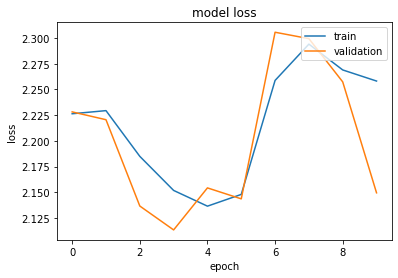

In [ ]:
figsize(6,4)
plt.plot(all_train_loss)
plt.plot(all_val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
def predict(test_loader, input_dim, sequence_length, hidden_dim, batch_size):
    test_losses = []
    a_weights = []
    
    state_h, state_c = model.init_state(batch_size)
    state_h = state_h.to(device)
    state_c = state_c.to(device)
    criterion = nn.CrossEntropyLoss()
    
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.reshape(-1, sequence_length, input_dim).to(device)
            images, labels = images.to(device), labels.to(device)
            output, h, a_out = model(images, (state_h, state_c))
    
            for each_a_out in a_out:
                a_weights.append(each_a_out)
                
            test_loss = criterion(output, labels)
            test_losses.append(test_loss.item())
    
    print("Test loss: {:.3f}".format(np.mean(test_losses)))

    return a_weights


In [ ]:
weights = predict(test_loader, input_dim, sequence_length, hidden_dim, batch_size=100)

Test loss: 2.146


In [ ]:
len(weights[0])

784

In [ ]:
numbers = 10

In [ ]:
mnist_weights = [weights[i].squeeze().cpu().numpy() for i in range(numbers)]
len(mnist_weights)

10

In [ ]:
ranks = []
for i in range(numbers):
    mnist_ranks = np.array([783 - x for x in rankdata(mnist_weights[i], method='ordinal')])
    ranks.append(mnist_ranks)

len(ranks)

10

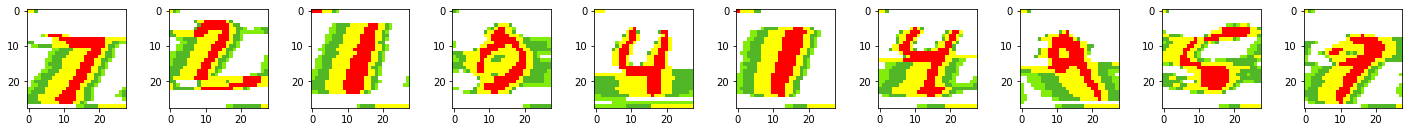

In [ ]:
figsize(25,4)
viridis = cm.get_cmap('viridis', 784)
colors = viridis(np.linspace(0, 1, 784))
red = np.array([1, 0, 0, 1])
yellow = np.array([1, 1, 0, 1])
green = np.array([0.32, 0.72, 0.15, 1])
lime = np.array([0.51, 0.93, 0.04, 1])
white = np.array([1, 1, 1, 1])
# colors[:65, :] = red
# colors[65:150, :] = yellow
# colors[150:200, :] = green
# colors[200:350, :] = lime
# colors[350:, :] = white
colors[:100, :] = red
colors[100:250, :] = yellow
colors[250:350, :] = green
colors[350:450, :] = lime
colors[400:, :] = white
colors = ListedColormap(colors)
for i in range(numbers):
    #title('Attention')
    plt.subplot(2, numbers, i+1)
    plt.imshow(ranks[i].reshape((28,28)), cmap=colors)

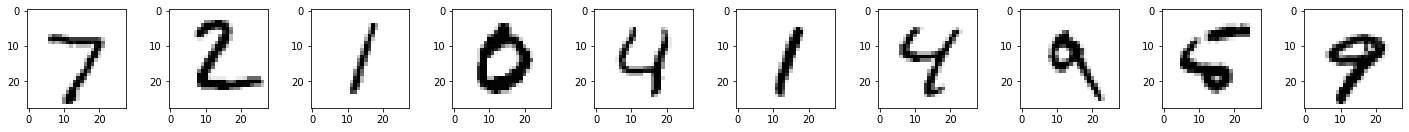

In [ ]:
for i in range(numbers):
    plt.subplot(2, numbers, i+1)
    plt.imshow(test_dataset[i][0].squeeze().reshape((28,28)), cmap='binary')

In [ ]:
 test_dataset[0][0].shape

torch.Size([1, 28, 28])